**Indiquer dans la boîte ci-dessous vos noms et prénoms**

Abdelraouf KESKES   et  Salim MOULOUEL

## Partie 1 - Description du problème

Dans ce notebook  on va s'intéresser à un problème très important dans le milieu du football , il consistera à essayer 
de trouver un lien entre le couple (Taille , Poids) d'un joueur et son ( accélaration ) car si on arrive à concevoir un système intelligent général permettant de prédire toutes les informations lièes à la rapidité ( accélération , Vitesse en sprint , agilité , réactions ) avec une prédiction très elevée ça peut révolutionner  tout le domaine de recrutement dans les clubs et ils pourront voir si ce joueur convient réellement à leur tactique de jeu ou pas . Dans notre cas , on va s'interésser à la colonne ( acceleration ) pour le moment , et on va concidérer ce problème comme étant un probème de classification et non pas de regression .
La classification sera ternaire ainsi : 
- < 65 : lent <=> -1 
- [65,80[ : moyen <=> 0
- [80,100] : rapide <=> +1

## Partie 2 - Modèle

Dans ce problème on va opter pour un apprentissage supervisé  dans un premier temps par KNN , et ensuite on testera d'autres classifieurs dans le but d'améliorer l'accuracy .

- Avantages du KNN : il s'adapte a des classifications autres que des classifications binaires simples et son apprentissage est à O(1) en terme de complexité .
- Inconvéniants du KNN  : la complexité de la prédiction est mauvaise , ça contredit aussi un peu le raisonnement humain qui prend généralement  beaucoup de temps à apprendre , mais une fois qu'il a bien appris et compris , il pourra répondre avec un temps très raisonnable voire même  instantanément 

Par rapport aux données on doit donc regrouper pour chaque joueur sa taille , son poids  et son accélération qu'on doit transformer en 3 classes ultérieurement .

## Partie 3 - Code

In [2]:
########################################  librairies ###############################################
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
# Permet d'afficher les figures directement dans le notebook:
%matplotlib inline

In [49]:
######################   Extraction des données utiles  #############################################
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 1000)

df_player = pd.read_csv('../soccer/player.csv')
df_playerAttrs = pd.read_csv('../soccer/playerattributes.csv'  )

df_player = df_player[['player_api_id' , 'height' , 'weight']]
df_playerAttrs  = df_playerAttrs[['player_api_id' , 'acceleration' ]].groupby('player_api_id' , as_index=False).mean()


df = pd.merge(df_player, df_playerAttrs, on='player_api_id', how='inner')
df.drop('player_api_id', axis=1, inplace=True)

In [4]:
#######################################  Classes utiles #############################################
class LabeledSet:  
    
    def __init__(self, input_dimension):
        self.input_dimension = input_dimension
        self.nb_examples = 0
        # Pour faire un dataset de training et de test  correcte  
        self.class_indexes = dict()
    
    def addExample(self,vector,label):
        if (self.nb_examples == 0):
            self.x = np.array([vector])
            self.y = np.array([label])
        else:
            self.x = np.vstack((self.x, vector))
            self.y = np.concatenate(   ( self.y  ,  np.array([label]) )   )
            
        #pour garder l'aspect général  quelque soit le nbr de classes on sauvgarde les indices car on en aura besoin
        #pour plusieurs traitements  le plus important d entre eux est le split Train/Test
        if ( label in self.class_indexes ):
            self.class_indexes[label].append( self.nb_examples )
        else :
            self.class_indexes[label] = [  self.nb_examples ]
            
        self.nb_examples = self.nb_examples + 1
    
    #Renvoie la dimension de l'espace d'entrée
    def getInputDimension(self):
        return self.input_dimension
    
    #Renvoie le nombre d'exemples dans le set
    def size(self):
        return self.nb_examples
    
    #Renvoie la valeur de x_i
    def getX(self, i):
        return self.x[i]
        
    
    #Renvouie la valeur de y_i
    def getY(self, i):
        return(self.y[i])
    
################################### Fonction utiles #######################################
def plot2DSet(dataset):
    from matplotlib.colors import ListedColormap
    x=dataset.x[:,0]
    y=dataset.x[:,1]
    classes = dataset.y
    cmap = ListedColormap([ 'green', 'yellow','red'])
    plt.scatter(x, y, c=classes, label=classes,cmap=cmap)
    plt.colorbar()
    unique_classes = list(set(classes))
    plt.table(cellText=[[-1], [0] , [+1]], loc='lower right',
              colWidths=[0.2],rowColours=[ 'green', 'yellow','red'],
             rowLabels=['Lent','Moyen','Rapide'],
              colLabels=['classes'])

def label( data ):
    if ( data < 65 ) : return -1 
    if ( data >= 65 and data < 80 ) : return 0
    if ( data >= 80 ) : return +1 
    return 0

def Train_Test_Split(dataset, training_percent  ):
    
    trainSet = LabeledSet (dataset.getInputDimension())
    testSet  = LabeledSet (dataset.getInputDimension())
    
    for key in dataset.class_indexes : 
        
        size = len ( dataset.class_indexes[key] ) 
        
        train_sliced = dataset.class_indexes[key][0:int( training_percent * size )]
        for index in train_sliced :
            trainSet.addExample ( dataset.getX(index) , dataset.getY(index) ) 
            
        test_sliced = dataset.class_indexes[key][int( training_percent * size ):]
        for index in test_sliced :
            testSet.addExample ( dataset.getX(index) , dataset.getY(index) )
            
    return trainSet , testSet

def convert_df_to_ls( df , data_cols_count ):
    matrix = df.as_matrix()
    ls = LabeledSet( data_cols_count )
    for row in matrix :
        ls.addExample ( row[:data_cols_count] , label (row[data_cols_count]) )
    return ls
    
    
##################################### Classifieurs ######################################### 
class Classifier:
    def __init__(self, input_dimension):
        raise NotImplementedError("Please Implement this method")
    
    
    #Permet de calculer la prediction sur x => renvoie un score
    def predict(self, x):
        raise NotImplementedError("Please Implement this method")

    
    #Permet d'entrainer le modele sur un ensemble de données
    def train(self, labeledSet):
        raise NotImplementedError("Please Implement this method")
    
    #Permet de calculer la qualité du système 
    def accuracy(self, dataset):
        S = 0
        n = dataset.size()  
        for i in range(n):
            if ( self.predict (dataset.getX(i)) * dataset.getY(i) > 0 ) : 
                S += 1
        return (S*100.00/n )

class KNN(Classifier):
   
    def __init__(self, input_dimension , k ):
        self.k = k 
        self.input_dimension = input_dimension
        
    #Permet de calculer la prediction sur x => renvoie un score
    def predict(self, x):
        distances =[]
        for i in range (self.model.size()):
            #Distance Euclédienne fait par moi même
            # np.sqrt(( self.model.getX(i)[0] -  x[0] )**2  +  ( self.model.getX(i)[1] - x[1] )**2 )
            #Pour des Dimensions énormes faut penser a utiliser une fonction  prédéfinie Ex : np.linalg.norm
            distances.append( np.linalg.norm(self.model.getX(i)-x) ) 
        #Sort distances
        distances = np.argsort(np.array(distances)) 
        S = 0 
        for i in range(self.k):
            #Pas la peine de faire la moyenne
            S +=  self.model.getY(distances[i])
        avg = S *1.0 / self.k
        if ( avg < -0.33 ) : return -1 
        if ( avg >= -0.33 and avg <= 0.33 ) : return 0
        if ( avg > 0.33 ) : return +1 
    
        
    #Permet d'entrainer le modèle sur un ensemble de données
    def train(self, labeledSet):
        self.model = labeledSet

## Partie 4 - Protocole expérimental

Tout d'abord on va faire une  visualisation des données qu'on a :

In [4]:
df.head(5)

,height,weight,acceleration
0,182.88,187,60.000000
1,170.18,146,76.000000
2,170.18,163,75.538462
3,182.88,198,50.217391
4,182.88,154,51.120000


In [5]:
input_dimensions = 2
dataset = convert_df_to_ls ( df ,  input_dimensions )

##### Visualisation des données 

#### Figure 1

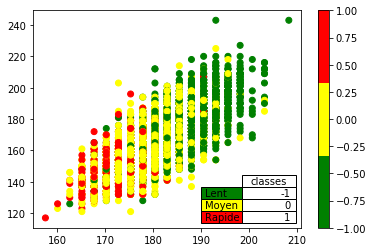

In [6]:
plot2DSet(dataset)

#### Figure 2-1

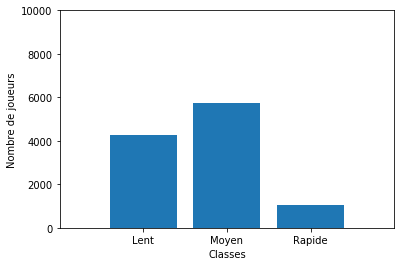

In [17]:
plt.ylabel('Nombre de joueurs')
plt.xlabel('Classes')
plt.hist([5000 , 2000 , 10000 ] )
plt.axis([-2 , 2 , 0 , 10000 ])

x  = list ( dataset.class_indexes.keys() )
y  = [ len(dataset.class_indexes[key]) for key in dataset.class_indexes ]

LABELS = ["Lent" ,"Moyen",  "Rapide" ]

plt.bar(x, y , align='center')
plt.xticks(x, LABELS )
plt.show()

#### Figure 2-2

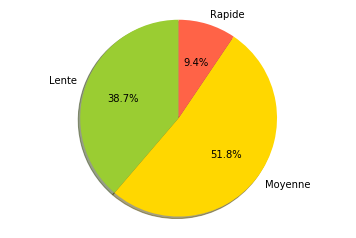

In [22]:
labels = 'Lente', 'Moyenne', 'Rapide'
sizes = y
colors = ['yellowgreen', 'gold', 'tomato']

plt.pie(sizes, labels=labels, colors=colors, 
        autopct='%1.1f%%', shadow=True, startangle=90)

plt.axis('equal')
plt.show()

#### Figure 3

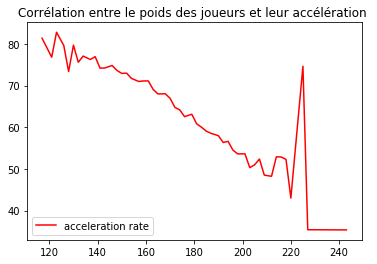

In [8]:
df_w = df[['weight','acceleration']].groupby('weight' , as_index=False).mean()
matrix = df_w.as_matrix()
poids = matrix[:,0]
accelerations = matrix[:,1]
plt.plot( poids , accelerations ,'r' )
plt.title("Corrélation entre le poids des joueurs et leur accélération ")
plt.legend(('acceleration rate',),loc="lower left") # why is this not working
plt.show()

#### Figure 4

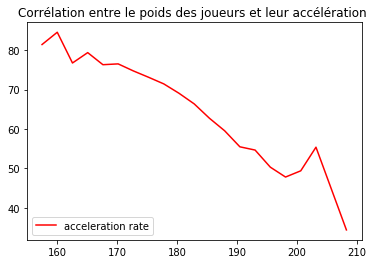

In [9]:
df_h = df[['height','acceleration']].groupby('height' , as_index=False).mean()
matrix = df_h.as_matrix()
poids = matrix[:,0]
accelerations = matrix[:,1]
plt.plot( poids , accelerations ,'r' )
plt.title("Corrélation entre le poids des joueurs et leur accélération ")
plt.legend(('acceleration rate',),loc="lower left") # why is this not working
plt.show()

##### Apprentissage

In [6]:
TrainSet , TestSet = Train_Test_Split (dataset , 0.8 )
knn=KNN( input_dimensions , 10 )
knn.train(TrainSet)

In [11]:
df.head(5)

,height,weight,acceleration
0,182.88,187,60.000000
1,170.18,146,76.000000
2,170.18,163,75.538462
3,182.88,198,50.217391
4,182.88,154,51.120000


for k =  1  The accuracy is :  26.47989154993222
for k =  2  The accuracy is :  26.47989154993222
for k =  3  The accuracy is :  26.47989154993222
for k =  4  The accuracy is :  26.47989154993222
for k =  5  The accuracy is :  26.47989154993222
for k =  6  The accuracy is :  26.47989154993222
for k =  7  The accuracy is :  26.47989154993222
for k =  8  The accuracy is :  26.47989154993222
for k =  9  The accuracy is :  26.47989154993222
for k =  10  The accuracy is :  26.47989154993222
for k =  11  The accuracy is :  26.47989154993222
for k =  12  The accuracy is :  26.47989154993222
for k =  13  The accuracy is :  26.47989154993222
for k =  14  The accuracy is :  26.47989154993222
for k =  15  The accuracy is :  26.47989154993222
for k =  16  The accuracy is :  26.47989154993222
for k =  17  The accuracy is :  26.47989154993222
for k =  18  The accuracy is :  26.47989154993222
for k =  19  The accuracy is :  26.47989154993222
for k =  20  The accuracy is :  26.47989154993222
for k =  

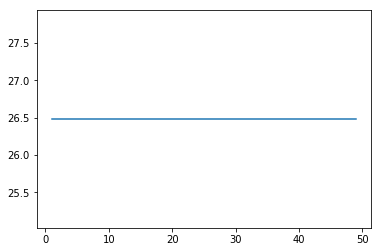

In [13]:
k_list = list()
accuracy_list = list()


for k in range (1,50):
    k_list.append(k)
    new_knn = KNN( input_dimension , k )
    new_knn.train ( trainSet )
    acc = new_knn.accuracy(testSet)
    accuracy_list.append(acc)
    print ("for k = ",k," The accuracy is : ", acc  )
    
plt.plot( k_list ,accuracy_list )
plt.show()

##### Tentative de Classification Binaire

On va essayer de tester avec une classification binaire  : 
- Mauvais = -1 ( Mauvaise performance  "accélération < 70"  ) 
- Bon = +1  Sinon

In [23]:
def label_bin( data ):
    if ( data < 70 ) : return -1 
    return +1

class KNN_binaire (KNN):
    #Permet de calculer la prediction sur x => renvoie un score
    def predict(self, x):
        distances =[]
        for i in range (self.model.size()):
            #Distance Euclédienne fait par moi même
            # np.sqrt(( self.model.getX(i)[0] -  x[0] )**2  +  ( self.model.getX(i)[1] - x[1] )**2 )
            #Pour des Dimensions énormes faut penser a utiliser une fonction  prédéfinie Ex : np.linalg.norm
            distances.append( np.linalg.norm(self.model.getX(i)-x) ) 
        #Sort distances
        distances = np.argsort(np.array(distances)) 
        S = 0 
        for i in range(self.k):
            #Pas la peine de faire la moyenne
            S = S + self.model.getY(distances[i])
        if ( S < 0 ) : return -1
        return +1
    
def convert_df_to_ls( df , data_cols_count ):
    matrix = df.as_matrix()
    ls = LabeledSet_binaire( data_cols_count )
    for row in matrix :
        ls.addExample ( row[:data_cols_count] , label_bin (row[data_cols_count]) )
    return ls


In [27]:
input_dimensions = 2
dataset_bin = convert_df_to_ls ( df ,  input_dimensions )

TrainSet , TestSet = Train_Test_Split (dataset_bin , 0.8 )
knn=KNN_binaire( input_dimensions , 10 )
knn.train(TrainSet)

In [28]:
print ("accuracy is : ",knn.accuracy(TestSet))

accuracy is :  67.96204247627655


#### Test avec un arbre de décision

In [8]:
import math
def classe_majoritaire(labeledSet):
    S = 0 
    for i in range(labeledSet.size()):
        S += labeledSet.getY(i)
    if ( S < 0 ) : 
        return -1 
    return +1

def shannon(P):
    if ( len(P) == 1 ) :
        return 0
    Sum = 0 
    for pi in P :
        if ( pi != 0):
               Sum += pi*(math.log(pi,len(P)))
    return -Sum


#Fonction générale  elle se limite pas à la classification binaire
def entropie(LabeledSet):
    #Calculer la frequence d apparition de chaque classe
    dictFreq = dict() 
    for i in range (LabeledSet.size()):
        #Récupère le Label 
        classe = LabeledSet.getY(i)
        #Si la classe existe deja  on incremente Sinon on la crée 
        if ( classe in dictFreq ) : 
            dictFreq[classe] += 1
        else :
            dictFreq[classe] = 1
    #transformer la frequence de chaque classe en probabilité  en divisant sur le nbr total
    for i in dictFreq :
        #Python division float ne marche pas automatiquement
        dictFreq[i] = dictFreq[i] *1.0/ LabeledSet.size()
    return (shannon(dictFreq.values()))

def discretise(LSet, col):
    """ LabelledSet * int -> tuple[float, float]
        col est le numéro de colonne sur X à discrétiser
        rend la valeur de coupure qui minimise l'entropie ainsi que son entropie.
    """
    # initialisation:
    min_entropie = 1.1  # on met à une valeur max car on veut minimiser
    min_seuil = 0.0     
    # trie des valeurs:
    ind= np.argsort(LSet.x,axis=0)
    
    # calcul des distributions des classes pour E1 et E2:
    inf_plus  = 0               # nombre de +1 dans E1
    inf_moins = 0               # nombre de -1 dans E1
    sup_plus  = 0               # nombre de +1 dans E2
    sup_moins = 0               # nombre de -1 dans E2       
    # remarque: au départ on considère que E1 est vide et donc E2 correspond à E. 
    # Ainsi inf_plus et inf_moins valent 0. Il reste à calculer sup_plus et sup_moins 
    # dans E.
    for j in range(0,LSet.size()):
        if (LSet.getY(j) == -1):
            sup_moins += 1
        else:
            sup_plus += 1
    nb_total = (sup_plus + sup_moins) # nombre d'exemples total dans E
    
    # parcours pour trouver le meilleur seuil:
    for i in range(len(LSet.x)-1):
        v_ind_i = ind[i]   # vecteur d'indices
        courant = LSet.getX(v_ind_i[col])[col]
        lookahead = LSet.getX(ind[i+1][col])[col]
        val_seuil = (courant + lookahead) / 2.0;
        # M-A-J de la distrib. des classes:
        # pour réduire les traitements: on retire un exemple de E2 et on le place
        # dans E1, c'est ainsi que l'on déplace donc le seuil de coupure.
        if LSet.getY(ind[i][col]) == -1:
            inf_moins += 1
            sup_moins -= 1
        else:
            inf_plus += 1
            sup_plus -= 1
        # calcul de la distribution des classes de chaque côté du seuil:
        nb_inf = (inf_moins + inf_plus)*1.0     # rem: on en fait un float pour éviter
        nb_sup = (sup_moins + sup_plus)*1.0     # que ce soit une division entière.
        # calcul de l'entropie de la coupure
        val_entropie_inf = shannon([inf_moins / nb_inf, inf_plus  / nb_inf])
        val_entropie_sup = shannon([sup_moins / nb_sup, sup_plus  / nb_sup])
        val_entropie = (nb_inf / nb_total) * val_entropie_inf + (nb_sup / nb_total) * val_entropie_sup
        # si cette coupure minimise l'entropie, on mémorise ce seuil et son entropie:
        if (min_entropie > val_entropie):
            min_entropie = val_entropie
            min_seuil = val_seuil
    return (min_seuil, min_entropie)

def divise(LSet,att,seuil):
    set1 = LabeledSet(LSet.getInputDimension)
    set2 = LabeledSet(LSet.getInputDimension)
    for i in range (LSet.size()):
        if ( LSet.getX(i)[att] < seuil ) :
            set1.addExample ( LSet.getX(i) , LSet.getY(i) )
        else :
            set2.addExample ( LSet.getX(i) , LSet.getY(i) )
    return (set1,set2)


class ArbreBinaire:
    def __init__(self):
        self.attribut = None   # numéro de l'attribut
        self.seuil = None
        self.inferieur = None # ArbreBinaire Gauche (valeurs <= au seuil)
        self.superieur = None # ArbreBinaire Gauche (valeurs > au seuil)
        self.classe = None # Classe si c'est une feuille: -1 ou +1
        
    def est_feuille(self):
        """ rend True si l'arbre est une feuille """
        return self.seuil == None
    
    def ajoute_fils(self,ABinf,ABsup,att,seuil):
        """ ABinf, ABsup: 2 arbres binaires
            att: numéro d'attribut
            seuil: valeur de seuil
        """
        self.attribut = att
        self.seuil = seuil
        self.inferieur = ABinf
        self.superieur = ABsup
    
    def ajoute_feuille(self,classe):
        """ classe: -1 ou + 1
        """
        self.classe = classe
        
    def classifie(self,exemple):
        """ exemple : numpy.array
            rend la classe de l'exemple: +1 ou -1
        """
        if self.est_feuille():
            return self.classe
        if exemple[self.attribut] <= self.seuil:
            return self.inferieur.classifie(exemple)
        return self.superieur.classifie(exemple)
    
    def to_graph(self, g, prefixe='A'):
        """ construit une représentation de l'arbre pour pouvoir
            l'afficher
        """
        if self.est_feuille():
            g.node(prefixe,str(self.classe),shape='box')
        else:
            g.node(prefixe, str(self.attribut))
            self.inferieur.to_graph(g,prefixe+"g")
            self.superieur.to_graph(g,prefixe+"d")
            g.edge(prefixe,prefixe+"g", '<='+ str(self.seuil))
            g.edge(prefixe,prefixe+"d", '>'+ str(self.seuil))
        
        return g
    
    


def construit_AD(LSet,epsilon):
    un_arbre= ArbreBinaire()
    if ( entropie(LSet) <= epsilon ) : 
        un_arbre.ajoute_feuille(classe_majoritaire(LSet))
    else :
        entropie_min = 1.1
        selected_attr = -1 
        seuilMin = 0
        ## tous les descritises des attributs 
        nbr_attrs = len(LSet.getX(0))
        
        for attr in range(nbr_attrs):
            seuil , entrop  = discretise(LSet,attr)
            if ( entrop < entropie_min ) :
                entropie_min = entrop 
                selected_attr = attr
                seuilMin = seuil
        
        set1 , set2 = divise(LSet,selected_attr,seuilMin)
        un_arbre.ajoute_fils( construit_AD(set1,epsilon)  ,  construit_AD(set2,epsilon)  , selected_attr  ,seuilMin )
        
    return un_arbre

class ArbreDecision(Classifier):
    # Constructeur
    def __init__(self,epsilon):
        # valeur seuil d'entropie pour arrêter la construction
        self.epsilon= epsilon
        self.racine = None
    
    # Permet de calculer la prediction sur x => renvoie un score
    def predict(self,x):
        # classification de l'exemple x avec l'arbre de décision
        # on rend 0 (classe -1) ou 1 (classe 1)
        classe = self.racine.classifie(x)
        if (classe == 1):
            return(1)
        else:
            return(-1)
    
    # Permet d'entrainer le modele sur un ensemble de données
    def train(self,set):
        # construction de l'arbre de décision 
        self.set=set
        self.racine = construit_AD(set,self.epsilon)

    # Permet d'afficher l'arbre
    def plot(self):
        gtree = gv.Digraph(format='png')
        return self.racine.to_graph(gtree)
    #Permet de calculer la qualité du système 
    def accuracy(self, dataset):
        l=[]
        casok=0
        for i in range(dataset.size()):
            if(self.predict(dataset.getX(i))==dataset.getY(i)):
                casok+=1
        return casok/float(dataset.size())


In [ ]:
# un exemple d'utilisation:
ad=ArbreDecision(0.0)       
ad.train(TrainSet)              

print("accuracy:", ad.accuracy(TestSet))    

#test de l'affichage 
ad.plot()

In [27]:
TrainSet , TestSet = Train_Test_Split (dataset , 0.8 )
TestSet = Train_Test_Split (TestSet , 0.02 )[1]
knn=KNN( input_dimensions , 10 )
knn.train(TrainSet)
knn.predict([180,180])

0

####  <span style="color:red">RecursionError: maximum recursion depth exceeded while calling a Python object</span>

#### Test avec une forêt aléatoire  ( Random Forest ) prédéfinie  de sklearn

In [80]:
#Préparation des données
df_test = df.copy(deep=True)
df_test['acceleration'] = df_test['acceleration'].apply( lambda x: 'low'if x<65 else ('high' if x>=80 else 'medium') )
df_test.head(5)

,height,weight,acceleration
0,182.88,187,low
1,170.18,146,medium
2,170.18,163,medium
3,182.88,198,low
4,182.88,154,low


In [81]:
df_test['is_train'] = np.random.uniform(0, 1, len(df)) <= .75
df_test.head()

,height,weight,acceleration,is_train
0,182.88,187,low,True
1,170.18,146,medium,True
2,170.18,163,medium,True
3,182.88,198,low,False
4,182.88,154,low,True


In [82]:
train, test = df_test[df_test['is_train']==True], df_test[df_test['is_train']==False]
print('le nombre d exemples pour le Training :', len(train))
print('le nombre d exemples pour le Test :',len(test))
features = df.columns[:2]
y = pd.factorize(train['acceleration'])[0]
y

le nombre d exemples pour le Training : 8376
le nombre d exemples pour le Test : 2684


array([0, 1, 1, ..., 1, 1, 0])

###### Remarque :
- le nombre d'arbres par défaut , il est à 10 
- le nombre de processus d'executions est à 2 ( Programmation concurrente ) pour un meilleur temps d'execution 
- random_state : par rapport au générateur de nombre aléatoire qui utilise le seed pour faire ça , on l'initialise à 0 de préférence 

In [83]:
#Training
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_jobs=2, random_state=0)
clf.fit(train[features], y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=2,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [86]:
from sklearn.metrics import accuracy_score

preds = clf.predict(test[features])
trues  = pd.factorize(test['acceleration'])[0]
print ( 'La prediction avec une Random Forest est avec une accuracy de ',accuracy_score(trues,preds)*100.00  )

La prediction avec une Random Forest est avec une accuracy de  64.34426229508196


In [93]:
acc = list()
for n in range ( 2 , 101 ) :
    clf = RandomForestClassifier(n_estimators=n , n_jobs=2, random_state=0)
    clf.fit(train[features], y)
    preds = clf.predict(test[features])
    trues  = pd.factorize(test['acceleration'])[0]
    acc.append ( accuracy_score(trues,preds)*100.00  )

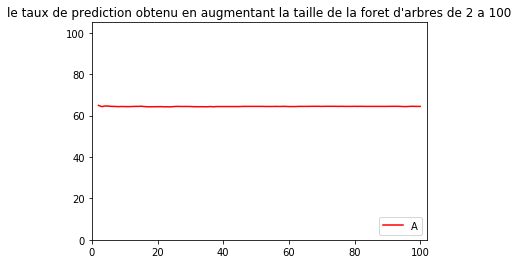

In [94]:
plt.plot( list(range(2,101)) , acc ,'r' )
plt.title("le taux de prediction obtenu en augmentant la taille de la foret d'arbres de 2 a 100")
plt.legend('Accuracy' , loc='lower right')
plt.axis([0, 102, 0, 105])
plt.show()

## Partie 5 - Résultats

Les résultats qu'on a obtenus sont : 
##### A) Figures lièes aux données 
1) Dans la Figure 1 on voit clairement que les données sont très denses et proches  et on voit aussi qu'il y a une pseudo-séparation entre les 3 classes (Rapide = Rouge , Moyenne = Jaune , Lente = Verte) , les données ne sont pas très séparables  mais on garde quand même un espoir pour notre classifieur qu'il puisse prédire  avec une accuracy qui dépasse les 50% . 

2) Dans la Figure 2-1 et 2-2 , on voulait voir le nombre de joueurs  par classe , pour la classe moyenne et la classe rapide on s'attendait à ces résultats c-a-d que la classe moyenne soit majoritaire et la classe rapide soit minoritaire  mais pour la classe lente on s'attendait pas vraiment à ça , et les deux figures montrent qu'elle est toute proche de la classe moyenne avec 38.7 % des joueurs

3) La figure 3 et la figure 4 , avaient les mêmes buts , c'était de chercher ou plutôt de confirmer l'intuition qu'il y ait une corrélation et un lien  entre la taille et l'accélération ( respectivement le poids et l'accélération ) ,  et effectivement les deux figures  montrent clairement  qu'il y a une forte corrélation disproportionnelle entre la taille ( respectivement le poids ) et l'accélération  c-a-d plus la  taille ( respectivement le poids ) est grande  plus l'accélération  est faible et vice versa 

##### B) Résultats et Figures liès à l'apprentissage 
4) KNN Ternaire : On voit que notre classifieur KNN ternaire ne nous a pas donné une accuracy plus de 50% , il est même très loin et il n'a pas dépassé les 27% quelque soit la valeur de K attribué , on constate aussi qu'il est resté à la même valeur d'accuracy pour 50 valeurs de K différentes , ce qui est décévant comme résultat .

5) KNN Binaire : Dans ce cas là on divise les joueurs en deux classes bonne / Mauvaise  accélération  ( -1 , + 1 ) et on constate qu'il se comporte largement mieux et avec un K=10 on a obtenu une accuracy de 68%  ce qui n'est pas du tout négligeable

6) Arbre de décision : En gardant la même classification binaire , on a essayé  de tester une arbre de décision pour voir ce que ça donne or on a obtenu une erreur liée au nombre d'appels  récursifs autorisé par python c-a-d que notre classifieur a dépassé les 999 appels récursifs imbriqués   et donc l'executions s'est arrêté .

7) Forêt aléatoire de la librairie ' sklearn' : on arrive à la partie qui nous a donné le meilleur résultat et une meilleure accuracy  qui a atteint presque 65% en gardant une classification Ternaire , par contre on voit clairement  que même en augmentant le nombre d'arbres l'accuracy reste constante .
   On a quand même réussit à dépasser les 50% d'accuracy et c'était notre objectif dès le départ 

###### Partie 6 - Analyse

On arrive à la partie la plus importante de notre  problème c'est l'analyse des résultats  qu'on a obtenus .

- Les données  sont très denses et très proches , et on parle aussi de joueurs de football donc si on a traité les données  des gens ordinaires qui s'entraînent pas régulièrement , il est clair qu"on aura de meilleurs résultats sur ce problème  , or vu que les joueurs de football travaillent et s'entraînent pour améliorer leurs performances  donc on a eu beaucoup d'exemples qui ont fait l'exception à la règle des 3 classes tels que des joueurs qui sont moyen de ( taille,poids )  mais qui sont très lents ou très rapides , des joueurs qui sont grand de (taille,poids)  mais sont rapide  et ça justifie aussi l'augmentation soudaine dans l'accélération ( Figure 2-1 et 2-2 ) malgré le fait que la taille (respectivement poids) était grand .


- par rapport aux  pourcentages de distribution entre les 3 catégories , plus précisémment le résultat étonnant qui dit que 38.7 % des joueurs on une faible accélération , donc c'est une information qu' on a pu extraire et qu'on savait pas.Il faut que les clubs de foot revoient ça et essayent de le corriger car c'est terrible comme information dans un sport ou on arrête pas de courrir  pendant 90 min , surtout sur le fait que la majorité des scores des matchs de football sont très liés à la vitesse et à l'accélération ( c'est un autre problème qu'on peut traîter ) car tout but dans le foot est causé par une erreur et le plus généralement les erreurs sont lié à la vitesse d'execution , accélération , réaction et inattention .


- par rapport à la classification , globalement l'accuracy ne peut pas atteindre une valeur très elevée , le KNN prouve exactement le fait que les données sont très proches et denses et donc pour avoir une meilleure accuracy  il fallait peu être voir  les 500 ou 1000 voisins proches  car avec  un seul voisin  ou 50 voisins on obtenait généralement le même résultat vu la densité des données .

 Avec un seul arbre de décision on a pas pu aller loin car les appels récursifs s'enchainaient et vu la densité qu'on avait il était très difficile d'atteindre un niveau ou les données seraient bien séparables et donc on pouvait pas atteindre l'entropie minimale même avec une profondeur de 999 noeuds  . 
 
 Notre meilleur résultat de classification on l'a obtenu avec les randomForests prédéfinies de sklearn , il est très bien codé et très optimal en temps d'execution pour des données massives et le résultat de 68% prouve qu'il y'a quand même une logique et une information à tirer de la taille et du poids  , il faut peu être construire un vecteur de données beaucoup plus informatif et riche , par exemple on rajoute l'âge de la personne , la league dont il joue ( car ça diffère la vitesse de jeu entre les leagues par exemple en angleterre les joueurs doivent être très rapides d'executions avec une vitesse énorme etc....  par rapport à l'italie ) et beaucoup d'autres paramètres  statistiques sur le joueur , qui nous permettent de mieux le classifier en Vitesse ( accélération , rapidité d'execution , reaction , sprint ) en mauvais , moyen et bon  et de maximiser l'accuracy . 